# Problem Statement

In the realm of Neverland, where enchantment stretched far and wide, there lived a kind-hearted cattleman named Grassland Gus. His farm, Moo Meadows, was the sole source of the most delicious meat and milk in the kingdom. The people of Neverland would come from far and wide to procure these treasures.

Some procured these items directly from the farm at wholesale rates, while others obtained them from nearby groceries at retail prices. Fresh items were available at a premium, while frozen ones were sold at standard prices.

Gus packaged his dairy and meat in Enchanted Boxes. Each box held a different combination of meat and milk, and depending on their quality, some boxes were more valuable than others.

To purchase these magical boxes, the denizens of Neverland used Wishing Coins, which are tokens earned through acts of kindness. Every buyer had their own unique Magic Key, which kept track of all their purchases.

All exchanges of the kingdom are logged in the Enchanted Scroll, details of which are given in the file purchase.csv. The file contains records of purchases made over the last five months, including the date of purchase, the customer's magic key, the box ID purchased and purchase unit. Denizens select boxes to purchase from a list written on parchment. The dataset Boxes.csv enumerates all available boxes, including the box ID, product quality, delivery option, quantity of milk (cauldron), quantity of meat (stones) and box unit price.

There is no specific train.csv for this contest. Only **"purchase.csv"** and **"boxes.csv"** are given. You have to do everything from these two files.

**"problem 2.csv"** is given for you to predict, **"sample submission 2.csv"** is also there to help you about the submission template.

Magic Keys given in **“problem 2.csv”** purchased only one box of milk and/or meat in the first 15 days of March-2019. You need to predict which boxes were purchased by these customers in this period. Prepare and submit as submission.csv following the the template (sample submission 2.csv).

----
**Evaluation**
The evaluation metric for this problem is Accuracy. Accuracy is a fundamental evaluation metric in machine learning, particularly for classification tasks. It measures the proportion of correctly predicted instances out of the total instances in the dataset.

# Generic testing
This code is to test out the generic theory or eda for the problem datasets

In [24]:
import pandas as pd
import numpy as np
purchase = pd.read_csv("Problem 1/purchase.csv")
box = pd.read_csv("Problem 1/boxes.csv")


## Dropping ducplicates, nan values and impossible values

In [25]:
purchase = purchase.dropna().drop_duplicates() # Drop NaN values and duplicates
positive_box_count_mask = purchase['BOX_COUNT'] >= 0
purchase = purchase[positive_box_count_mask]
purchase['PURCHASE_DATE'] = pd.to_datetime(purchase['PURCHASE_DATE'], format='%d/%m/%Y')
purchase = purchase.sort_values(by='PURCHASE_DATE') # Sort purchase data by purchase date in ascending order
purchase.count()


PURCHASE_DATE    2455723
MAGIC_KEY        2455723
BOX_ID           2455723
BOX_COUNT        2455723
dtype: int64

# 0. New dynamic method:

## calculate_avg_time_between_purchases and feature_extraction

In [26]:
def calculate_avg_time_between_purchases(group):
    if len(group) > 1:
        return np.mean(group['PURCHASE_DATE'].diff().dt.days)
    else:
        return 150
    
def feature_extraction(purchase,grouped_df,box):
    # Task 1: Calculate the frequency of purchases for each Magic Key within specific time intervals (bi-weekly and monthly)
    print('1/6 Extracting Bi-Weekly and Monthly Purchase Count...')
    biweekly_purchase_count = purchase.groupby(['MAGIC_KEY', pd.Grouper(key='PURCHASE_DATE', freq='2W')]).size().unstack(fill_value=0)
    monthly_purchase_count = purchase.groupby(['MAGIC_KEY', pd.Grouper(key='PURCHASE_DATE', freq='ME')]).size().unstack(fill_value=0)

    # Task 2: Calculate the average time between purchases for each Magic Key
    print('2/6 Extracting Average Time between purchase...')
    # avg_time_between_purchases = grouped_df.apply(calculate_avg_time_between_purchases) 
    avg_time_between_purchases = 0

    # Task 3 days_since_last_purchase
    print('3/6 Extracting Days since last purchase...')
    last_purchase_date = grouped_df['PURCHASE_DATE'].max()
    days_since_last_purchase = (purchase['PURCHASE_DATE'].max() - last_purchase_date).dt.days.copy()
    
    # Task 4 purchase_count and total_spent
    print('4/6 Extracting purchase_count and total_spent...')
    merged_df = pd.merge(purchase, box, on='BOX_ID') 
    merged_df['SPENT'] = merged_df['BOX_COUNT'] * merged_df['UNIT_PRICE']
    grouped_df = merged_df.groupby('MAGIC_KEY') 
    purchase_count = grouped_df.size().rename('Purchase_Count') 
    total_spent = grouped_df['SPENT'].sum().rename('Total_Spent')
    # total_spent = grouped_df['UNIT_PRICE'].sum().rename('Total_Spent')

    # Task 5  total_milk_quantity & total_meat_quantity
    print('5/6 Extracting total_milk_quantity & total_meat_quantity...')
    total_milk_quantity = grouped_df['MILK'].sum().rename('Total_Milk_Quantity')
    total_meat_quantity = grouped_df['MEAT'].sum().rename('Total_Meat_Quantity')
    
    # Task 6 num_purchases_first_15_days and num_purchases_last_15_days
    # I will give it a try by dropping them too
    print('6/6 Extracting num_purchases_first_15_days and num_purchases_last_15_days...')
    first_15_days_purchase = merged_df[merged_df['PURCHASE_DATE'].dt.day <= 15]
    num_purchases_first_15_days = first_15_days_purchase.groupby(['MAGIC_KEY', first_15_days_purchase['PURCHASE_DATE'].dt.month]).size().groupby('MAGIC_KEY').sum()
    last_15_days_purchase = merged_df[merged_df['PURCHASE_DATE'].dt.day > 15]
    num_purchases_last_15_days = last_15_days_purchase.groupby(['MAGIC_KEY', last_15_days_purchase['PURCHASE_DATE'].dt.month]).size().groupby('MAGIC_KEY').sum()
    
    # Task 7 Most common box 
    print('$$ Extracting Most common box...')
    most_common_boxes = merged_df.groupby('MAGIC_KEY')['BOX_ID'].agg(lambda x: x.mode()[0])


    # Combine all features into a DataFrame
    features = pd.DataFrame({
        'Biweekly_Purchase_Count': biweekly_purchase_count.mean(axis=1),
        'Monthly_Purchase_Count': monthly_purchase_count.mean(axis=1),
        'Avg_Time_Between_Purchases': avg_time_between_purchases,
        'Days_Since_Last_Purchase': days_since_last_purchase
    })
    purchase_history_features = pd.concat([purchase_count, total_spent], axis=1) # Create a new DataFrame with purchase history features
    features = features.join(purchase_history_features, how='left')
    box_features_df = pd.concat([total_milk_quantity, total_meat_quantity], axis=1)
    features = features.join(box_features_df, how='left')
    features['Num_Purchases_First_15_Days'] = num_purchases_first_15_days     # Dropping 2 features 
    features['Num_Purchases_Last_15_Days'] = num_purchases_last_15_days       # Dropping 2 features
    features['Most_common_box'] = most_common_boxes
    features = features.fillna(0)
    features = features.drop(columns=['Avg_Time_Between_Purchases'])          # Dropping avg time between purchases 
    return features
    


## Set time boundary

In [27]:
purchase_oct_nov = purchase[(purchase['PURCHASE_DATE'].dt.year == 2018) &
                                    ((purchase['PURCHASE_DATE'].dt.month == 10) |
                                     (purchase['PURCHASE_DATE'].dt.month == 11))]
grouped_df_oct_nov = purchase_oct_nov.groupby('MAGIC_KEY') # Group by MAGIC_KEY
features = feature_extraction(purchase_oct_nov,grouped_df_oct_nov,box)


1/6 Extracting Bi-Weekly and Monthly Purchase Count...
2/6 Extracting Average Time between purchase...
3/6 Extracting Days since last purchase...
4/6 Extracting purchase_count and total_spent...
5/6 Extracting total_milk_quantity & total_meat_quantity...
6/6 Extracting num_purchases_first_15_days and num_purchases_last_15_days...
$$ Extracting Most common box...


## Labelling features

In [28]:
# Mode used labelling features  

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
def Labelling_features(features, purchase, end_date):

    start_date = pd.Timestamp('2018-10-01')
    end_date = pd.Timestamp(end_date)
    purchase_half = purchase[(purchase['PURCHASE_DATE'] >= start_date) & (purchase['PURCHASE_DATE'] <= end_date)]

    # purchase_half = purchase[(purchase['PURCHASE_DATE'].dt.year == year) &  
    #                                 (purchase['PURCHASE_DATE'].dt.month == month) &   # Filter by month
    #                                 (purchase['PURCHASE_DATE'].dt.day <= 15)]  # I passed entire month instead of just 15 days
    
    most_common_boxes = purchase_half.groupby('MAGIC_KEY')['BOX_ID'].agg(lambda x: x.mode()[0])
    most_common_boxes_df = most_common_boxes.to_frame(name='Most_Common_Box')

    features_with_labels = pd.merge(features, most_common_boxes_df, left_index=True, right_index=True, how='left')
    features_with_labels = features_with_labels.dropna(subset=['Most_Common_Box'])
    features_with_labels = features_with_labels.rename(columns={'Most_Common_Box': 'labels'})
    features_with_labels ['labels'] = features_with_labels['labels'] - 1
    return features_with_labels
    

In [29]:
# features = Labelling_features(features,purchase, 2018,12) # for december of 2018

features = Labelling_features(features,purchase, '2018-12-15') # for december of 2018

## Model Define

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def define_model(n_input, n_hidden_layer, n_unit_per_layer,dropout_rate=0.25, l2_penalty=0.01):
    model = Sequential()
    model.add(Dense(n_unit_per_layer, input_shape=(n_input,), activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l2_penalty)))
    model.add(Dropout(dropout_rate))

    # Adding one additional hidden layer
    model.add(Dense(n_unit_per_layer, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l2_penalty)))
    model.add(Dropout(dropout_rate))
    

    model.add(Dense(290, activation='softmax'))  # 290 classes, so output layer has 290 units and uses softmax activation
    return model

## Model train on OCT-NOV data. label DEC

In [31]:
labels = features['labels'].to_numpy()
features_pure = (features.drop(columns=['labels'])).to_numpy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pure)
num_node = 100

model_oct_nov = define_model(features_scaled.shape[1], 1, num_node)
model_oct_nov.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)
hist_oct_nov = model_oct_nov.fit(X_train, y_train, epochs=100, batch_size=4096)
test_loss, test_accuracy = model_oct_nov.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

model_oct_nov_weights = model_oct_nov.get_weights()


d:\Apps\Anaconda_2024\envs\competition\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1929 - loss: 7.4234
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5485 - loss: 3.4731
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6223 - loss: 2.3960
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6578 - loss: 1.9075
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6755 - loss: 1.6524
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6891 - loss: 1.5038
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6999 - loss: 1.4105
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7115 - loss: 1.3424
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7191 - loss: 1.2950
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7268 - loss: 1.2548
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7325 - loss: 1.2242
Epoch 12/100
126/126 ━━━━━━━━━

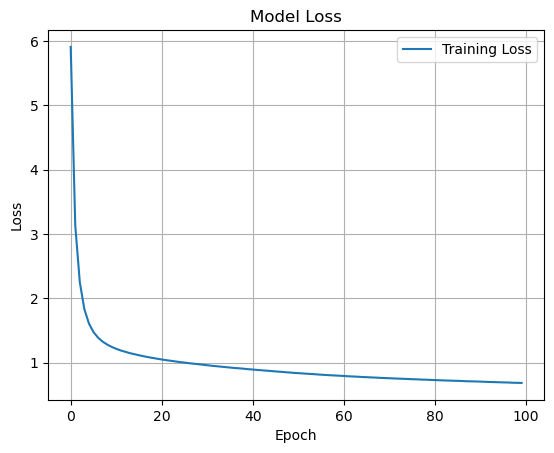

In [32]:
import matplotlib.pyplot as plt
plt.plot(hist_oct_nov.history['loss'], label='Training Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model train on OCT-NOV-DEC Label Jan

In [33]:
# Time boundary, OCT, Nov, Dec
purchase_oct_nov_dec = purchase[(purchase['PURCHASE_DATE'].dt.year == 2018) &
                                    ((purchase['PURCHASE_DATE'].dt.month == 10) |
                                     (purchase['PURCHASE_DATE'].dt.month == 11) |
                                     (purchase['PURCHASE_DATE'].dt.month == 12))]
grouped_df_oct_nov_dec = purchase_oct_nov_dec.groupby('MAGIC_KEY') # Group by MAGIC_KEY
features = feature_extraction(purchase_oct_nov_dec,grouped_df_oct_nov_dec,box)

# Labelling 
print("Feature Labelling is going on...")
# features = Labelling_features(features,purchase, 2019, 1) # for  of 2019
features = Labelling_features(features,purchase, '2019-01-15') # for January of 2019

#defining elimentary things
labels = features['labels'].to_numpy()
features_pure = (features.drop(columns=['labels'])).to_numpy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pure)

1/6 Extracting Bi-Weekly and Monthly Purchase Count...
2/6 Extracting Average Time between purchase...
3/6 Extracting Days since last purchase...
4/6 Extracting purchase_count and total_spent...
5/6 Extracting total_milk_quantity & total_meat_quantity...
6/6 Extracting num_purchases_first_15_days and num_purchases_last_15_days...
$$ Extracting Most common box...
Feature Labelling is going on...


In [34]:

# Model defining and setting previous weights
model_oct_nov_dec = define_model(features_scaled.shape[1], 1, num_node)
model_oct_nov_dec.set_weights(model_oct_nov_weights)
model_oct_nov_dec.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)
hist_oct_nov_dec = model_oct_nov_dec.fit(X_train, y_train, epochs=100, batch_size=4096)
test_loss, test_accuracy = model_oct_nov_dec.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

model_oct_nov_dec_weights = model_oct_nov_dec.get_weights()

d:\Apps\Anaconda_2024\envs\competition\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7586 - loss: 1.3296
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7699 - loss: 1.1001
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7768 - loss: 1.0346
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7847 - loss: 0.9894
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7876 - loss: 0.9629
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7902 - loss: 0.9443
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7926 - loss: 0.9307
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7935 - loss: 0.9209
Epoch 9/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7943 - loss: 0.9152
Epoch 10/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7968 - loss: 0.9021
Epoch 11/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7976 - loss: 0.8978
Epoch 12/100
165/165 ━━━━━━━━━

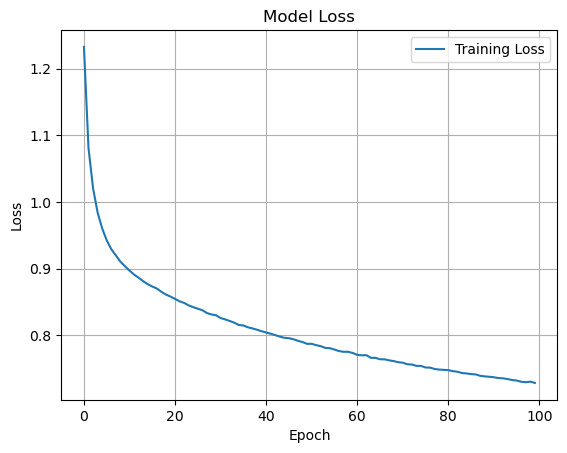

In [35]:
import matplotlib.pyplot as plt
plt.plot(hist_oct_nov_dec.history['loss'], label='Training Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model train on OCT-NOV-DEC-Jan Label Feb

In [36]:
# Time boundary, OCT, Nov, Dec, Jan
purchase_oct_nov_dec_jan = purchase[((purchase['PURCHASE_DATE'].dt.year == 2018) | (purchase['PURCHASE_DATE'].dt.year == 2019)) &
                                    ((purchase['PURCHASE_DATE'].dt.month == 10) |
                                     (purchase['PURCHASE_DATE'].dt.month == 11) |
                                     (purchase['PURCHASE_DATE'].dt.month == 12) |
                                     (purchase['PURCHASE_DATE'].dt.month == 1))]
grouped_df_oct_nov_dec_jan = purchase_oct_nov_dec_jan.groupby('MAGIC_KEY') # Group by MAGIC_KEY
features = feature_extraction(purchase_oct_nov_dec_jan,grouped_df_oct_nov_dec_jan,box)

# Labelling 
# features = Labelling_features(features,purchase, 2019, 2) # for February of 2019
features = Labelling_features(features,purchase, '2019-02-15') # for February of 2019

#defining elimentary things
labels = features['labels'].to_numpy()
features_pure = (features.drop(columns=['labels'])).to_numpy()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pure)

1/6 Extracting Bi-Weekly and Monthly Purchase Count...
2/6 Extracting Average Time between purchase...
3/6 Extracting Days since last purchase...
4/6 Extracting purchase_count and total_spent...
5/6 Extracting total_milk_quantity & total_meat_quantity...
6/6 Extracting num_purchases_first_15_days and num_purchases_last_15_days...
$$ Extracting Most common box...


In [37]:
# Model defining and setting previous weights
model_oct_nov_dec_jan = define_model(features_scaled.shape[1], 1, num_node)
model_oct_nov_dec_jan.set_weights(model_oct_nov_dec_weights)
model_oct_nov_dec_jan.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)
hist_oct_nov_dec_jan = model_oct_nov_dec_jan.fit(X_train, y_train, epochs=100, batch_size=4096)
test_loss, test_accuracy = model_oct_nov_dec_jan.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

model_oct_nov_dec_jan_weights = model_oct_nov_dec_jan.get_weights()

d:\Apps\Anaconda_2024\envs\competition\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7298 - loss: 1.1881
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7530 - loss: 1.0589
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7581 - loss: 1.0285
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7624 - loss: 1.0093
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7656 - loss: 0.9915
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7680 - loss: 0.9817
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7706 - loss: 0.9671
Epoch 8/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7726 - loss: 0.9591
Epoch 9/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7748 - loss: 0.9504
Epoch 10/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7774 - loss: 0.9414
Epoch 11/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7775 - loss: 0.9399
Epoch 12/100
205/205 ━━━━━━━━━

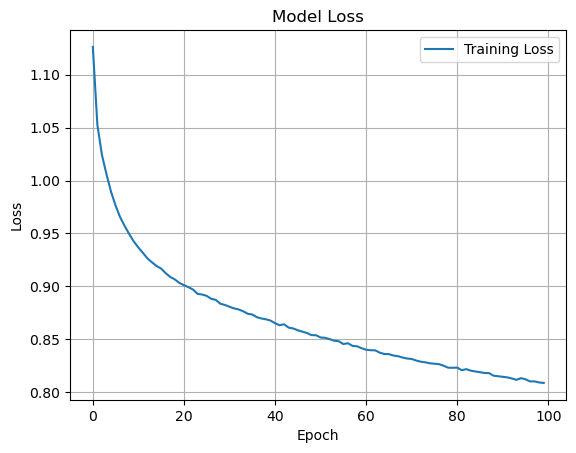

In [38]:
import matplotlib.pyplot as plt
plt.plot(hist_oct_nov_dec_jan.history['loss'], label='Training Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Saving and loading weights

In [ ]:
# Assuming model is your TensorFlow model object

model_oct_nov_dec_jan.save_weights('model.weights.h5')

# model = define_model(features_scaled.shape[1], 1, num_node)
# model.load_weights('model_weights.h5')

## Check Feb test

In [39]:
# Filter data for the first 15 days of February 2019
start_date = pd.Timestamp('2019-02-01')
end_date = pd.Timestamp('2019-02-15')
feb_data = purchase[(purchase['PURCHASE_DATE'] >= start_date) & (purchase['PURCHASE_DATE'] <= end_date)]

# Create DataFrame with 'MAGIC_KEY' as index and 'BOX_ID' as 'label'
feb_test = feb_data.set_index('MAGIC_KEY')[['BOX_ID']].rename(columns={'BOX_ID': 'label'})
feb_test = feb_test.reset_index()

In [40]:
grouped_df = purchase.groupby('MAGIC_KEY') # Group by MAGIC_KEY
features = feature_extraction(purchase,grouped_df,box)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
feb_test = feb_test.reset_index()
extracted_features_df = features.loc[feb_test['MAGIC_KEY']]
extracted_features_df

1/6 Extracting Bi-Weekly and Monthly Purchase Count...
2/6 Extracting Average Time between purchase...
3/6 Extracting Days since last purchase...
4/6 Extracting purchase_count and total_spent...
5/6 Extracting total_milk_quantity & total_meat_quantity...
6/6 Extracting num_purchases_first_15_days and num_purchases_last_15_days...
$$ Extracting Most common box...


,Biweekly_Purchase_Count,Monthly_Purchase_Count,Days_Since_Last_Purchase,Purchase_Count,Total_Spent,Total_Milk_Quantity,Total_Meat_Quantity,Num_Purchases_First_15_Days,Num_Purchases_Last_15_Days,Most_common_box
MAGIC_KEY,,,,,,,,,,
2918AD53FC5,0.166667,0.4,27,2,26.14,10.0,2.4,1.0,1.0,233.0
28F9F1C4022,0.166667,0.4,27,2,31.92,0.0,7.2,1.0,1.0,255.0
28F136BD796,0.250000,0.6,4,3,47.88,0.0,10.8,2.0,1.0,255.0
2CEF3F9E019,0.416667,1.0,6,5,107.90,84.0,11.2,4.0,1.0,143.0
2BE8E1C3686,0.250000,0.6,27,3,59.94,35.0,5.6,3.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...
2C7E8FEB228,0.416667,1.0,13,5,99.90,80.0,9.4,1.0,4.0,143.0
2C08F604F7D,0.416667,1.0,13,5,103.90,68.0,10.1,1.0,4.0,137.0
2CC80E6BA25,0.416667,1.0,13,5,79.80,0.0,16.5,2.0,3.0,106.0


In [41]:
# suitable for neural networks
X_sub = scaler.transform(extracted_features_df)
predictions = model_oct_nov_dec_jan.predict(X_sub)
predicted_classes = predictions.argmax(axis=1) 
predicted_classes

9283/9283 ━━━━━━━━━━━━━━━━━━━━ 8s 842us/step


array([230, 254, 254, ..., 105,  88,  88], dtype=int64)

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(feb_test['label'].values, (predicted_classes+1 ))

0.4938072521975081

## Submission

In [53]:
sample = pd.read_csv('Problem 2/sample submission 2.csv')
problem = pd.read_csv('Problem 2/problem 2.csv')
# reduced features 
extracted_features_df = features.loc[problem['MAGIC_KEY']]
extracted_features_df


,Biweekly_Purchase_Count,Monthly_Purchase_Count,Days_Since_Last_Purchase,Purchase_Count,Total_Spent,Total_Milk_Quantity,Total_Meat_Quantity,Num_Purchases_First_15_Days,Num_Purchases_Last_15_Days,Most_common_box
MAGIC_KEY,,,,,,,,,,
2C0B5F97180,0.416667,1.0,25,5,92.10,61.0,7.2,5.0,0.0,137.0
2C2F659EF00,0.416667,1.0,21,5,99.90,80.0,9.8,5.0,0.0,143.0
29D629EDF20,0.583333,1.4,9,7,85.62,71.6,0.0,4.0,3.0,238.0
2A7073E2FF0,0.416667,1.0,19,5,55.98,46.8,0.0,5.0,0.0,231.0
2A9B9BE1210,0.416667,1.0,7,5,92.70,74.7,8.0,2.0,3.0,270.0
...,...,...,...,...,...,...,...,...,...,...
2C49A3D7EAD,0.333333,0.8,27,4,79.92,40.0,7.4,4.0,0.0,134.0
2C49C75F0D8,0.166667,0.4,24,2,31.92,0.0,5.8,2.0,0.0,182.0
2C49CA2A632,0.250000,0.6,28,3,47.88,0.0,10.1,1.0,2.0,108.0


In [54]:
# suitable for neural networks
X_sub = scaler.transform(extracted_features_df)
predictions = model_oct_nov_dec_jan.predict(X_sub)
predicted_classes = predictions.argmax(axis=1) 
predicted_classes = predicted_classes + 1

  52/1360 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step

1360/1360 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step


In [55]:
# Create a DataFrame with MAGIC_KEY and PURCHASE columns
submit = pd.DataFrame({'MAGIC_KEY': problem['MAGIC_KEY'], 'BOX_ID': predicted_classes})
submit.to_csv('submit_p2_v1_.csv', index=False) 
submit.shape

(43518, 2)